In [12]:
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

In [13]:
import cs230_project_utilities as utils

In [14]:
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [15]:
def load_data():
    data = np.load('brain.npz')
    # brain_image is complex-valued
    brain_image, uniform_mask, vardens_mask, uniform_pdf, vardens_pdf = (data['im'], data['mask_unif'],
        data['mask_vardens'], data['pdf_unif'], data['pdf_vardens'])
    return brain_image, uniform_mask, vardens_mask, uniform_pdf, vardens_pdf

In [16]:
# Load data from brain.npz
brain_image, uniform_mask, vardens_mask, uniform_pdf, vardens_pdf = load_data()

# 1. MRI reconstruction from fully sampled Fourier Transform (k-space data)

In [17]:
def reconstruct_image_from_fully_sampled_fourier_transform(image):
    
    # Forward Fourier Transform
    fft = utils.signal_processing.fft_2D_centered(image)
    
    # Reconstruct original image from inverse Fourier Transform
    image_reconstruction = utils.signal_processing.ifft_2D_centered(fft)
    
    # Compute peak signal-to-noise ratio
    PSNR = utils.signal_processing.PSNR(np.abs(image_reconstruction), image, max_value=1.0) # may need to adjust max_value for different data
    print('PSNR of reconstrution: {}'.format(PSNR))
    
    # Plot results
    plt.subplot(3, 2, 1)
    plt.title('Original image')
    utils.plot.imshowgray(np.abs(image)) # np.abs() because image may be complex-valued

    plt.subplot(3, 2, 2)
    plt.title('FFT')
    utils.plot.imshowfft(fft)

    plt.subplot(3, 2, 3)
    plt.title('Reconstruction')
    utils.plot.imshowgray(np.abs(image_reconstruction))

    plt.subplot(3, 2, 5)
    plt.title('Error in reconstruction')
    square_error = np.square(np.abs(image) - np.abs(image_reconstruction))
    utils.plot.imshowgray(square_error)

### 1a. Reconstruct a human brain MRI

PSNR of reconstrution: 9.61125681471


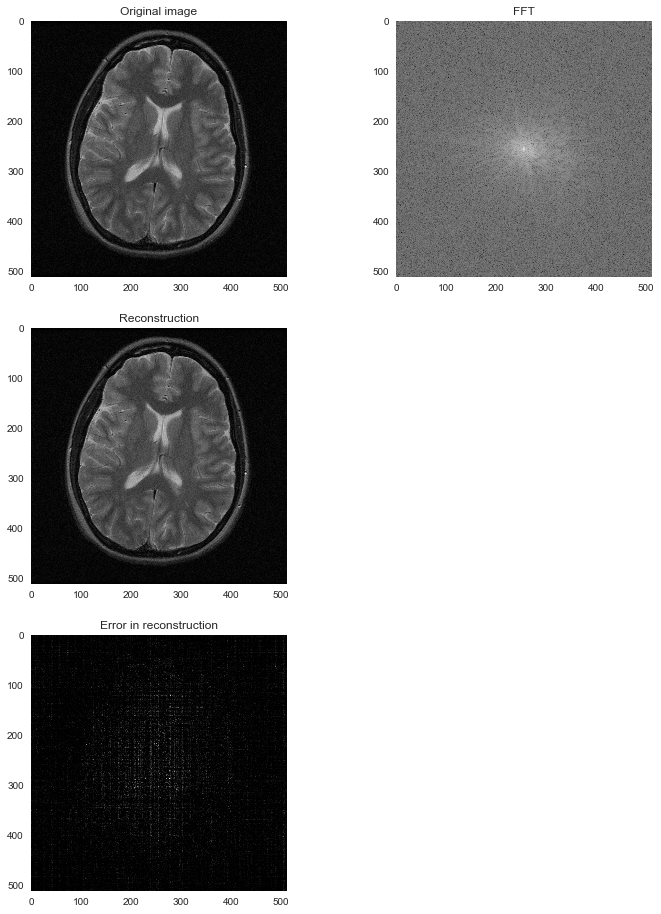

In [18]:
reconstruct_image_from_fully_sampled_fourier_transform(brain_image)

### 1b. The Shepp-Logan phantom is a popular standard test image for evaluating reconstruction algorithms

PSNR of reconstrution: 321.365531058


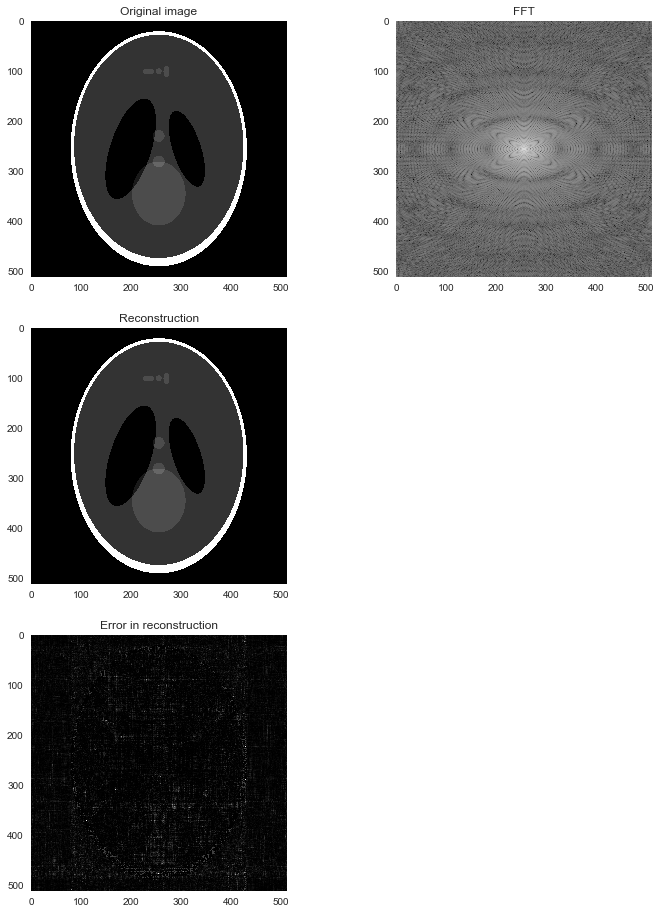

In [19]:
phantom = utils.phantom(512)
reconstruct_image_from_fully_sampled_fourier_transform(phantom)

# 2. Reconstruction from an *undersampled* Fourier Transform (k-space data)
Compares undersampling by masking FFTs using two different PDFs: uniform and variable density. Each mask preserves the same amount of coefficients (33%) but has very different reconstruction quality.

In [20]:
def reconstruct_image_from_undersampled_fourier_transform(image, mask, pdf):
    '''
    Undersamples the FFT of `image` by masking with `mask` having probability density function `pdf` and
    visualizes the results.
    '''
    # Forward Fourier Transform
    original_fft = utils.signal_processing.fft_2D_centered(image)
    
    # Undersample Fourier Transform and divide by PDF for density compensation
    masked_fft = (mask * original_fft) / pdf
    
    # Reconstruct image from undersampled Fourier Transform by compute the inverse Fourier Transform
    image_reconstruction = utils.signal_processing.ifft_2D_centered(masked_fft)
    
    # Compute peak signal-to-noise ratio
    PSNR = utils.signal_processing.PSNR(np.abs(image_reconstruction), image, max_value=1.0) # may need to adjust max_value for different data
    print('PSNR of reconstrution: {}'.format(PSNR))
    
    print('Mask preserves {0:.2f}% of FFT coefficients'.format(100.0 * mask.sum() / np.product(mask.shape)))

    plt.subplot(3, 2, 1)
    plt.title('Original image')
    utils.plot.imshowgray(np.abs(image)) # np.abs() because image may be complex-valued

    plt.subplot(3, 2, 2)
    plt.title('FFT')
    utils.plot.imshowfft(original_fft)

    plt.subplot(3, 2, 3)
    plt.title('Reconstruction')
    utils.plot.imshowgray(np.abs(image_reconstruction))

    plt.subplot(3, 2, 4)
    plt.title('Mask')
    utils.plot.imshowgray(mask)

    plt.subplot(3, 2, 5)
    plt.title('Error in reconstruction')
    square_error = np.square(np.abs(image) - np.abs(image_reconstruction))
    utils.plot.imshowgray(square_error)

    plt.subplot(3, 2, 6)
    plt.title('Sampled FFT')
    utils.plot.imshowfft(masked_fft)

### 2a. Uniformly undersample

PSNR of reconstrution: 4.76148543343
Mask preserves 33.33% of FFT coefficients


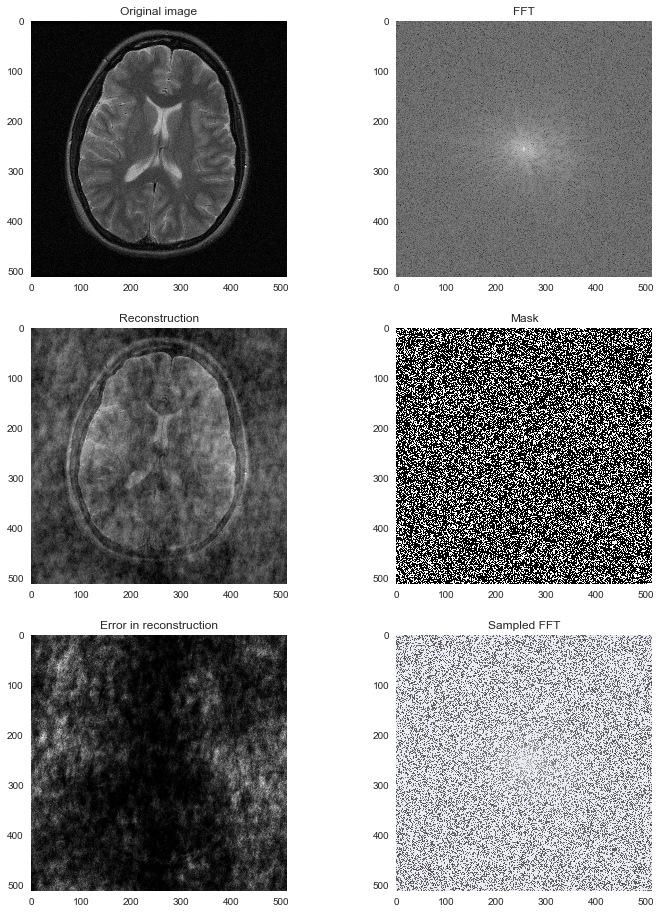

In [21]:
reconstruct_image_from_undersampled_fourier_transform(brain_image, uniform_mask, uniform_pdf)

### 2b. Undersample with a variable density PDF

PSNR of reconstrution: 9.45581314221
Mask preserves 33.33% of FFT coefficients


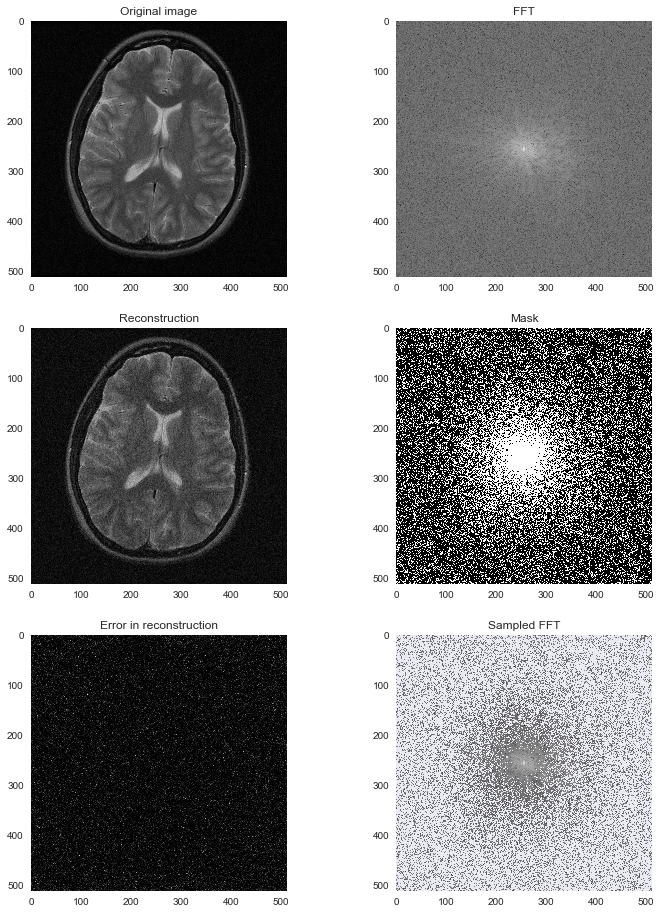

In [22]:
reconstruct_image_from_undersampled_fourier_transform(brain_image, vardens_mask, vardens_pdf)